# Exploration of the data

#### Get path to the raw data

In [34]:
import os
from pathlib import Path

from dotenv import load_dotenv
load_dotenv()
root_data = os.getenv("KAGGLE_FILES_DIR")
dataset_path = Path(os.getcwd(), "..", root_data)
raw = Path(dataset_path, "raw")

#### Read CSVs files with labels

In [3]:
import pandas as pd

labels_traintest15_train19 = pd.read_csv(Path(raw, 'labels', 'traintestLabels15_trainLabels19.csv'), header=0, usecols=["image", "level"])
labels_train19 = pd.read_csv(Path(raw, 'labels', 'trainLabels19.csv'), header=0, usecols=["id_code", "diagnosis"])
labels_train19.rename(columns={"id_code": "image", "diagnosis": "level"}, inplace=True)  # rename columns to match other datasets

labels_train15 = pd.read_csv(Path(raw, 'labels', 'trainLabels15.csv'), header=0, usecols=["image", "level"])
labels_test15 = pd.read_csv(Path(raw, 'labels', 'testLabels15.csv'), header=0, usecols=["image", "level"])


#### Shapes of labels CSVs

In [4]:
print(labels_traintest15_train19.shape)
print(labels_train19.shape)
print(labels_train15.shape)
print(labels_test15.shape)

(92364, 2)
(3662, 2)
(35126, 2)
(53576, 2)


#### Concatenate all labels with no duplicates

In [5]:
labels = pd.concat([labels_traintest15_train19, labels_train19, labels_train15, labels_test15], ignore_index=True).drop_duplicates()
labels.shape

(92364, 2)

##### Looks like `labels_traintest15_train19` labels contains all unique data.

#### Check images directories length

In [6]:
imgs_15 = Path(raw, 'resized_traintest15_train19')
imgs_19 = Path(raw, 'resized_test19')

print(len(list(imgs_15.glob("*"))))
print(len(list(imgs_19.glob("*"))))


92364
1928


#### Check if `traintestLabels15_trainLabels19.csv` contains all images from `resized_traintest15_train19`.

In [ ]:
missing = []

for label in labels[["image"]].values:
    p = Path(imgs_15, f"{label[0]}.jpg")
    if not p.exists():
        missing.append(label)
        print(f"Image {label[0]} not found in `resized_traintest15_train19`")

#### All images from `traintestLabels15_trainLabels19.csv` are present in `resized_traintest15_train19`.
#### Other CSVs and resized_test19 directory are not removed.

In [25]:
import shutil
shutil.rmtree(imgs_19)
shutil.move(imgs_15, Path(raw, "images"))
labels.to_csv(Path(raw, "labels.csv"), index=False)
shutil.rmtree(Path(raw, "labels"))

#### Make dirs for clases of data
I will simplify images into 2 categories - healthy (0) and non-healthy (DR for diabetic retinopathy, 1)

In [36]:
retinopathy_severity = {
    0: 0,
    1: 1,
    2: 1,
    3: 1,
    4: 1
}
for severity in retinopathy_severity.values():
    os.makedirs(Path(raw, str(severity)), exist_ok=True)

#### Move images to their classes

In [40]:
from tqdm import tqdm
images = Path(raw, "images")


# Map the 'level' column in the labels DataFrame using the retinopathy_severity dictionary
labels['level'] = labels['level'].map(retinopathy_severity)

for image in tqdm(images.glob("*")):
    label = labels[labels["image"] == image.stem]["level"].values[0]
    shutil.move(image, Path(raw, retinopathy_severity[label], image.name))

shutil.rmtree(images)

0it [00:00, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/isulim/Sages/retino-cnn/notebooks/../data/raw/images'

#### Split images into train, validation and test sets (80%/10%/10%)

In [54]:
import splitfolders

processed = Path(dataset_path, 'processed')
os.makedirs(processed, exist_ok=True)

splitfolders.ratio(raw, output=processed, seed=42, ratio=(0.8, 0.1, 0.1))

Copying files: 92364 files [00:58, 1584.17 files/s]


# Create train, validation, test datasets

In [8]:
import os
from pathlib import Path

from dotenv import load_dotenv
load_dotenv()
root_data = os.getenv("KAGGLE_FILES_DIR")
dataset_path = Path(os.getcwd(), "..", root_data)

In [9]:
import torchvision

processed = Path(dataset_path, 'processed')
train_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'train')), transform=None)
val_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'val')), transform=None)
test_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'test')), transform=None)

In [10]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

73890
9235
9239


## Explore image sizes

100%|██████████| 7389/7389 [01:41<00:00, 73.13it/s] 


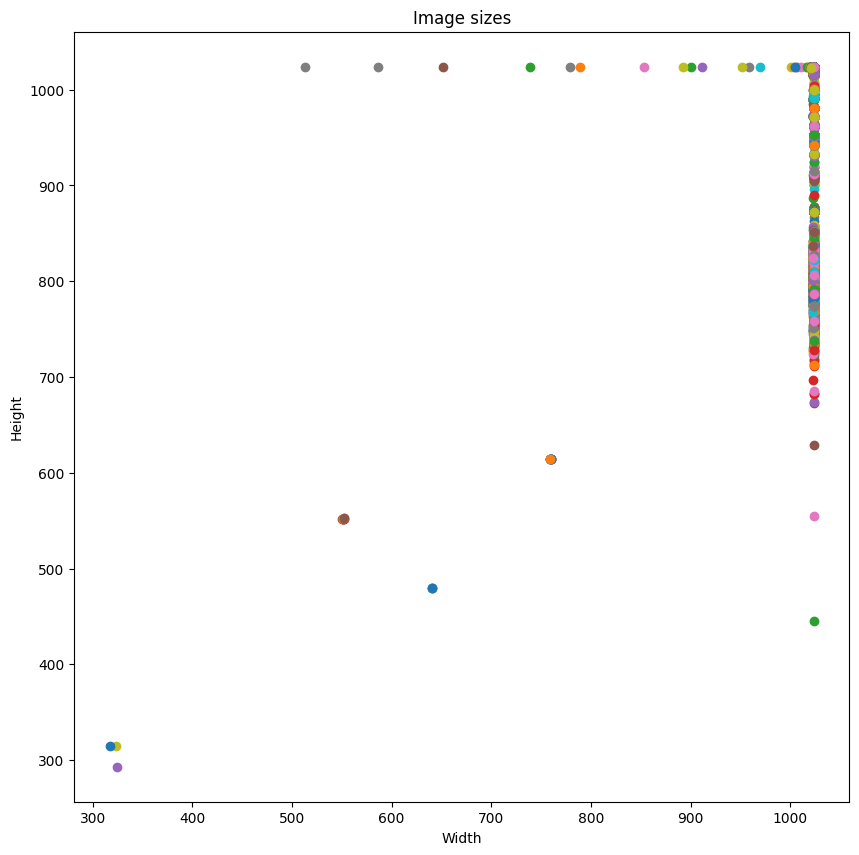

Lowest width: 317, lowest height: 293
Highest width: 1024, highest height: 1024
Average width: 1021.9101366896739, average height: 913.3560698335364


In [12]:
import matplotlib.pyplot as plt
from tqdm import tqdm

highest_width = 0
highest_height = 0

lowest_width = float("inf")
lowest_height = float("inf")

avg_width = 0
avg_height = 0

figure = plt.figure(figsize=(10, 10))

ran = range(1, len(train_dataset), 10)
for _ in tqdm(ran):
    img, label = train_dataset[_]
    size = img.size
    
    avg_width += size[0]
    avg_height += size[1]
    
    if size[0] < lowest_width:
        lowest_width = size[0]
    if size[1] < lowest_height:
        lowest_height = size[1]
    
    if size[0] > highest_width:
        highest_width = size[0]
    if size[1] > highest_height:
        highest_height = size[1]
    
    plt.scatter(size[0], size[1])
    

plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image sizes")
plt.show()
print(f"Lowest width: {lowest_width}, lowest height: {lowest_height}")
print(f"Highest width: {highest_width}, highest height: {highest_height}")
print(f"Average width: {avg_width / len(ran)}, average height: {avg_height / len(ran)}")

Average size is quite close to 1024x1024, but images will be resized to 256x256, to speed up training.
It looks like there is very litte images smaller than this size, so information loss should be minimal.

### Add transforms to the dataset

In [13]:
from pathlib import Path

import torchvision
transformations = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
])
train_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'train')), transform=transformations)
val_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'val')), transform=transformations)
test_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'test')), transform=transformations)

### Visualize some images from train dataset

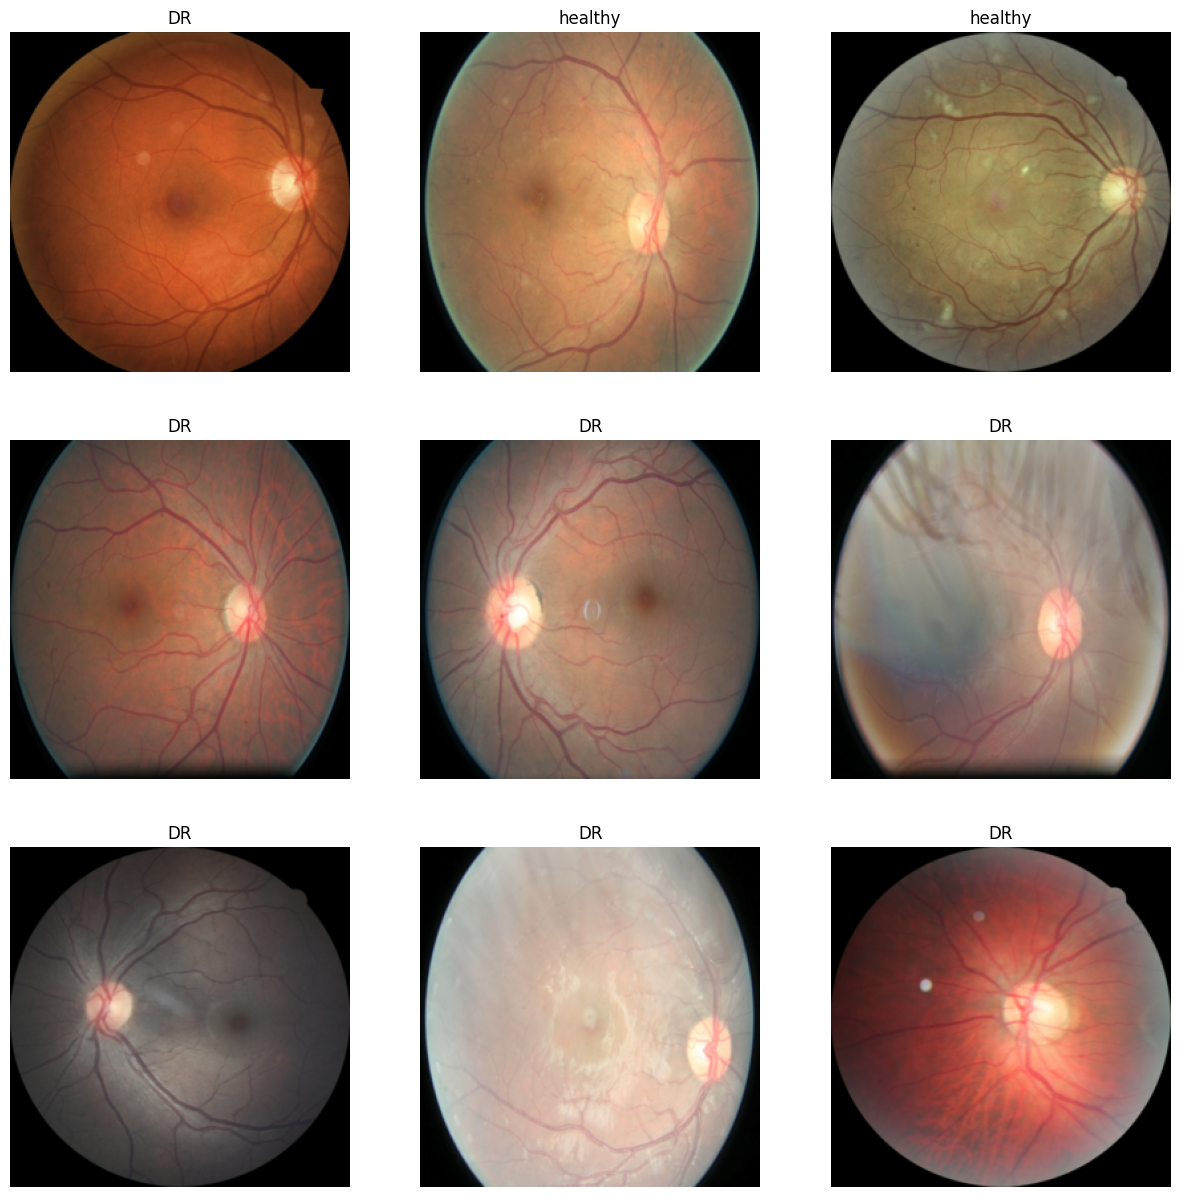

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

DR_CLASSES = {
    0: "healthy",
    1: "DR",
    2: "DR",
    3: "DR",
    4: "DR"
}

figure = plt.figure(figsize=(15, 15))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(DR_CLASSES[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    

# Dataloaders

In [41]:
import os
import torch
import torchvision

from pathlib import Path
from dotenv import load_dotenv

BATCH_SIZE = 8
LOADER_WORKERS = 8

load_dotenv()
root_data = os.getenv("KAGGLE_FILES_DIR")
dataset_path = Path(os.getcwd(), "..", root_data)
processed = Path(dataset_path, 'processed')


transformations = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'train')), transform=transformations)
val_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'val')), transform=transformations)
test_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'test')), transform=transformations)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKERS)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKERS)


### Size of datasets

In [42]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 73890
Validation dataset size: 9235
Test dataset size: 9239


In [43]:
image, label = train_dataset[0]
print(image.shape[0])
print(label)

3
0


# Define classifier
### Using CNN with 3 convolutional layers and 2 fully connected layers.

In [71]:
import torch
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self, input_size: torch.Size, initial_filters: int, out_classes: int, dropout: float = 0.25, device: str = "cpu", ):
        super(CNN, self).__init__()
        channels, _, _ = input_size
        self.device = device
        self.conv = nn.Sequential(
            nn.Conv2d(channels, initial_filters, kernel_size=3, stride=1, padding=1, device=self.device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(initial_filters, initial_filters * 2, kernel_size=3, stride=1, padding=1, device=self.device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(initial_filters * 2, initial_filters * 4, kernel_size=3, stride=1, padding=1, device=self.device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.perceptron = nn.Sequential(
            nn.Linear(self._get_conv_out_shape(input_size), initial_filters * 8, device=self.device),
            nn.Dropout(dropout),
            nn.Linear(initial_filters * 8, out_classes, device=self.device),
        )
    
    def forward(self, x: torch.Tensor):
        x = x.to(self.device)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.perceptron(x)
        return x
    
    def _get_conv_out_shape(self, input_size: torch.Size):
        with torch.no_grad():
            zeros = torch.zeros(*input_size, device=self.device)
            z = self.conv(zeros)
            z = torch.prod(torch.tensor(z.shape))
        return z


In [72]:
class EarlyStopper:
    def __init__(self, patience: int = 5, min_delta: float = 0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

For evaluation of the model, I will use accuracy and cross-entropy loss.

In [83]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate(
        model: nn.Module, 
        valid_loader: torch.utils.data.DataLoader, 
        loss_func: nn.Module, 
        epoch_no: int, 
        writer: torch.utils.tensorboard.SummaryWriter
):    
    model.eval()
    epoch_loss = 0
    correct_class = 0
    targets_list = []
    preds_list = []
    
    dataset_size = len(valid_loader.dataset)
    
    with torch.no_grad():
        device = model.device
        for inputs, targets in tqdm(valid_loader, desc="Evaluation: "):
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            pred_class = torch.argmax(output, dim=1)
            correct_class += (pred_class == targets).sum()
            loss = loss_func(output, targets)
            epoch_loss += loss.item() * inputs.size(0)
            
            # Count the number of targets and predictions
            targets_list.append(targets.cpu().numpy())
            preds_list.append(pred_class.cpu().numpy())
    
    avg_epoch_loss = epoch_loss / dataset_size
    accuracy = correct_class / dataset_size
    
    targets_np = np.concatenate(targets_list)
    preds_np = np.concatenate(preds_list)

    confusion_mat = confusion_matrix(targets_np, preds_np)
    precision = precision_score(targets_np, preds_np)
    recall = recall_score(targets_np, preds_np)
    f1 = f1_score(targets_np, preds_np)
    roc_auc = roc_auc_score(targets_np, preds_np)
    
    print(f"""Epoch: {epoch_no}
        Average epoch loss: {avg_epoch_loss}
        Confusion matrix: {confusion_mat}
        Accuracy: {accuracy}
        Precision: {precision:}
        Recall: {recall}
        F1: {f1}
        ROC AUC: {roc_auc}""")

    writer.add_scalar('Loss/train', avg_epoch_loss, epoch_no)
    writer.add_scalar('Accuracy/train', accuracy, epoch_no)
    writer.add_scalar('Precision/train', precision, epoch_no)
    writer.add_scalar('Recall/train', recall, epoch_no)
    writer.add_scalar('F1/train', f1, epoch_no)
    writer.add_scalar('ROC AUC/train', roc_auc, epoch_no)
    
    
    return avg_epoch_loss, accuracy, precision, recall, f1, roc_auc, confusion_mat

In [87]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

def train(
        model: nn.Module, 
        train_loader: torch.utils.data.DataLoader,
        valid_loader: torch.utils.data.DataLoader,
        max_epochs: int,
        optimizer: optim.Optimizer, 
        loss_func: nn.Module,
        patience: int = 3,
        min_delta: float = 0.001,
):
    
    writer = SummaryWriter('../runs/baseline_lr01_delta001_100eps')
    device = model.device
    early_stopping = EarlyStopper(patience=patience, min_delta=min_delta)
    best_avg_loss = float('inf')
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    for epoch in range(1, max_epochs + 1):
        model.train()
        for inputs, targets in tqdm(train_loader, desc=f"Train epoch {epoch}: "):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            predicted = model(inputs)
            loss = loss_func(predicted, targets)
            loss.backward()
            optimizer.step()
        
        avg_epoch_loss, accuracy, precision, recall, f1, roc_auc, confusion_mat = evaluate(model, valid_loader, loss_func, epoch, writer)
        
        lr_scheduler.step()
        
        if avg_epoch_loss < best_avg_loss:
            best_avg_loss = avg_epoch_loss
            torch.save(model.state_dict(), "../models/best_model_100eps.pt")
            print(f"Model saved on epoch {epoch}")
            
        if early_stopping.early_stop(avg_epoch_loss):
            print(f'''Early stopping on epoch {epoch}
            Validation loss: {avg_epoch_loss}
            Accuracy: {accuracy}
            Confusion Matrix: {confusion_mat}
            Precision: {precision}
            Recall: {recall}
            F1: {f1}
            ROC AUC: {roc_auc}''')
            break
    
    writer.close()


In [81]:
image, label = train_dataset[0]
model_params = {
    "input_size": image.shape,
    "initial_filters": BATCH_SIZE,
    "out_classes": len(train_dataset.classes),
    "device": "mps"
}
cnn = CNN(**model_params)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.1)

n_epochs = 100

In [78]:
train(cnn, train_loader, val_loader, n_epochs, optimizer, loss_func)

Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.39it/s]


Epoch: 1
        Average epoch loss: 0.5752437560507976
        Confusion matrix: [[6699   15]
 [2385  136]]
        Accuracy: 0.7401190996170044
        Precision: 0.9006622516556292
        Recall: 0.0539468464894883
        F1: 0.10179640718562874
        ROC AUC: 0.5258563544333054
Model saved on epoch 1


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.39it/s]


Epoch: 2
        Average epoch loss: 0.6010958890416006
        Confusion matrix: [[6683   31]
 [2370  151]]
        Accuracy: 0.7400108575820923
        Precision: 0.8296703296703297
        Recall: 0.059896866322887744
        F1: 0.11172770995190529
        ROC AUC: 0.5276398242844704


Evaluation: 100%|██████████| 1155/1155 [01:03<00:00, 18.20it/s]


Epoch: 3
        Average epoch loss: 0.6866874542956618
        Confusion matrix: [[6714    0]
 [2515    6]]
        Accuracy: 0.7276664972305298
        Precision: 1.0
        Recall: 0.002380007933359778
        F1: 0.004748713889988128
        ROC AUC: 0.5011900039666799


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.34it/s]


Epoch: 4
        Average epoch loss: 0.5642503275345904
        Confusion matrix: [[6712    2]
 [2397  124]]
        Accuracy: 0.7402274012565613
        Precision: 0.9841269841269841
        Recall: 0.04918683062276874
        F1: 0.09369097091046467
        ROC AUC: 0.5244444728031925
Model saved on epoch 4


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.49it/s]


Epoch: 5
        Average epoch loss: 0.5654345148130565
        Confusion matrix: [[6687   27]
 [2348  173]]
        Accuracy: 0.7428262233734131
        Precision: 0.865
        Recall: 0.06862356207854026
        F1: 0.12715913267181184
        ROC AUC: 0.5323010571786803


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.42it/s]


Epoch: 6
        Average epoch loss: 0.5535996286463725
        Confusion matrix: [[6710    4]
 [2385  136]]
        Accuracy: 0.7413102388381958
        Precision: 0.9714285714285714
        Recall: 0.0539468464894883
        F1: 0.10221721157459601
        ROC AUC: 0.5266755382283604
Model saved on epoch 6


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.49it/s]


Epoch: 7
        Average epoch loss: 0.5544650189864939
        Confusion matrix: [[6709    5]
 [2386  135]]
        Accuracy: 0.7410936951637268
        Precision: 0.9642857142857143
        Recall: 0.053550178500595
        F1: 0.10146561443066517
        ROC AUC: 0.5264027329798179


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.56it/s]


Epoch: 8
        Average epoch loss: 0.5646078422835019
        Confusion matrix: [[6711    3]
 [2415  106]]
        Accuracy: 0.7381700277328491
        Precision: 0.9724770642201835
        Recall: 0.04204680682268941
        F1: 0.0806083650190114
        ROC AUC: 0.5207999896490569


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.51it/s]


Epoch: 9
        Average epoch loss: 0.5601351773054715
        Confusion matrix: [[6711    3]
 [2422   99]]
        Accuracy: 0.7374120354652405
        Precision: 0.9705882352941176
        Recall: 0.03927013090043634
        F1: 0.07548608463591308
        ROC AUC: 0.5194116516879305


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.52it/s]

Epoch: 10
        Average epoch loss: 0.5667177972531539
        Confusion matrix: [[6584  130]
 [2237  284]]
        Accuracy: 0.7436924576759338
        Precision: 0.6859903381642513
        Recall: 0.11265370884569616
        F1: 0.19352640545144803
        ROC AUC: 0.5466455913903787
Early stopping on epoch 10
            Validation loss: 0.5667177972531539
            Accuracy: 0.7436924576759338
            Confusion Matrix: [[6584  130]
 [2237  284]]
            Precision: 0.6859903381642513
            Recall: 0.11265370884569616
            F1: 0.19352640545144803
            ROC AUC: 0.5466455913903787


Results are not satisfying, but model is working.
More experiments with image transformations and model hyperparameters will be continued in respective notebooks. 